# Naming the 256 XTerm colors

Why don't XTerm colors have names? X11 colors have names, as do web, SVG and
lipstick colors. There must be dozens of people worldwide who are reduced to
highlighting their text with `xterm-76`, instead of *fungal hallucination pink*
and *sizzling watermelon.* Well, not anymore. I have named all the colors, and
made the list available as an [rgb.txt](/rgb.txt) file, as well as a [color to
index](/xterm-256.txt) lookup file.

If you know me, then you also know that the rest of this post is a winding
article about colors, where I somehow find my way to explaining a data structure
you don't care about. But before we get to 3D nearest-neighbor search, a short
overview of prior art.

## Prior Art

There exists an attemp to map vim colors onto XTerm colors, reproduced e.g. in
[this list](https://www.ditig.com/publications/256-colors-cheat-sheet). The main
problem with the result is that Vim doesn't have enough colors to cover
everything, and also it uses names like "Blue3", which are boring.

A casual look around the internet reveals that people mostly use X11 colors (aka
`rgb.txt`), SVG colors or Web Colors whenever they need to refer to terminal
colors, but they don't match up very well, for two reasons:

1. There aren't enough of them. X11 only knows about 130 colors, SVG and Web
   colors similar numbers.
2. The shades are off - xterm-256 has a very specific set of swatches that are
   unlikely to appear in color database with 8 bits per channel.

As far as I could find, nobody has bothered to make an XTerm `rgb.txt` yet.

## What are the XTerm colors

[XTerm](https://en.wikipedia.org/wiki/Xterm) is terminal emulator that shipped
with the [X Window System](https://en.wikipedia.org/wiki/X_Window_System), which
you might know by its modern names X11 or X.org. It was one of the first
emulators to ship support for 256 colors, and to this day, most terminal
emulators behave like XTerm, and even declare themselves to be `xterm-256color`.

What I will now generously start refering to as the *XTerm Colorspace* consists
of 3 groups of color swatches:

1. 16 ANSI colors
2. 216 RGB colors
3. 24 shades of grey

Let's start by looking at the simplest part - the ANSI colors.

### ANSI Colors

In [1]:
from typing import NamedTuple


class Color(NamedTuple):
    """An RGB color with an optional list of names."""
    names: list[str]
    channels: tuple[float, float, float]


ANSI_COLORS_RGB = (
    (0x00, 0x00, 0x00),
    (0x80, 0x00, 0x00),
    (0x00, 0x80, 0x00),
    (0x80, 0x80, 0x00),
    (0x00, 0x00, 0x80),
    (0x80, 0x00, 0x80),
    (0x00, 0x80, 0x80),
    (0xC0, 0xC0, 0xC0),
    (0x80, 0x80, 0x80),
    (0xFF, 0x00, 0x00),
    (0x00, 0xFF, 0x00),
    (0xFF, 0xFF, 0x00),
    (0x00, 0x00, 0xFF),
    (0xFF, 0x00, 0xFF),
    (0x00, 0xFF, 0xFF),
    (0xFF, 0xFF, 0xFF),
)
"""The standard 16 ANSI colors."""

ANSI_COLOR_NAMES = (
    "Black",
    "Red",
    "Green",
    "Yellow",
    "Blue",
    "Magenta",
    "Cyan",
    "White",
    "Bright Black",
    "Bright Red",
    "Bright Green",
    "Bright Yellow",
    "Bright Blue",
    "Bright Magenta",
    "Bright Cyan",
    "Bright White",
)

ANSI_COLORS = [
    Color(
        names=[f"ansi-{i}", name],
        channels=tuple(c / 0xFF for c in ANSI_COLORS_RGB[i]),  # type: ignore
    )
    for i, name in enumerate(ANSI_COLOR_NAMES)
]

These are the ANSI colors. There are eight of them, and each additonally has a "bright variant".
They have names, too, but the names are strange. Let's view them as an HTML table.

In [2]:
from IPython import display
from typing import Iterable


def rgb_to_hex(rgb: tuple[float, float, float]) -> str:
    """Convert an RGB color to a hex string like ff0000 for red."""
    return "".join([f"{int(ch*255):02x}" for ch in rgb])


def contrast_color(rgb: tuple[float, float, float]) -> tuple[float, float, float]:
    """Return a color that will be legible against the background color."""
    r, g, b = rgb
    if r * 0.9 + g * 1.3 + b * 0.7 > 0.9:
        return (0, 0, 0)
    else:
        return (1, 1, 1)


def colors_html(colors: Iterable[Color]) -> Iterable[str]:
    """Generate an HTML table of colors."""
    yield "<table style>"
    for color in colors:
        fg_color = rgb_to_hex(contrast_color(color.channels))
        bg_color = rgb_to_hex(color.channels)
        yield f'<tr style="margin:0; background:#{bg_color}; color:#{fg_color}">'
        for name in color.names:
            yield f'<td style=\"border:none\">{name}</td>'
        yield f"<td style=\"border:none\">{bg_color}</td>"
        yield "</tr>"
    yield "</table>"



colors = (ANSI_COLORS[i] for i in range(16))
display.HTML("\n".join(colors_html(colors)))


You might notice that some of these colors are ridiculous. "Bright White" is a
color most humans would just call "White", and of course "Bright Black" is
non-sensical. But at least they *have* names.

### XTerm 256 colors and greyscale

The next thing on the list is the 216 RGB colors, followed by some shades of
grey. Before we visualize them, a word about how all of that works.

Modern colors, are mostly 24-bit (8 bits per RGB channel, like the familiar
`0xff00ff`), or 32-bit (adds an alpha channel). All this is sometimes called
*True Color.*

XTerm has 8-bit colors, which means that the color of any character on the
screen is given by a single byte with values from `0x00` to `0xff`. The astute
reader will notice that there is no way to divide 8 by 3 and end up happy,
unless 2-bit channels are the kind of thing that makes you happy.

### Base-6 all day, baby

Some 256-color systems hand-pick their color shades and use a lookup table, but
not XTerm. XTerm is old school UNIX stuff, and so XTerm uses base-6 channels. An
RGB color with 6 values per channel gives 216 combinations, which lets us put
legacy ANSI at the beginning for backwards compatibility, and still leaves room
at the end for fancy shades of grey and stuff.

The base-6 channels are converted to decimal as you'd expect - the only gotcha is
that that 256 can't be divided by 6, and also dark colors are pointless in
terminals with black background, and so the possible non-zero channel values are
all above `0x5f`.

Here's some quick conversion code from XTerm index into RGB:

In [3]:
# The xterm-256 color space is sparse at low luminosity.
CHANNEL_STEPFUNC = (0, 0x5F, 0x87, 0xAF, 0xD7, 0xFF)


def xterm_color(color_index: int) -> Color:
    """Convert the xterm color (0-255) to an RGB equivalent."""
    if color_index < 16:
        return Color(
            [f"{color_index}"],
            (
                ANSI_COLORS_RGB[color_index][0] / 0xFF,
                ANSI_COLORS_RGB[color_index][1] / 0xFF,
                ANSI_COLORS_RGB[color_index][2] / 0xFF,
            ),
        )

    if color_index >= 232:
        # Greyscale
        value = (0x8 + ((color_index - 232) * 0xA)) / 255
        return Color([f"{color_index}"], (value, value, value))

    red, r = divmod(color_index - 16, 6**2)
    green, blue = divmod(r, 6)

    return Color(
        [f"{color_index}"],
        (
            CHANNEL_STEPFUNC[red] / 255,
            CHANNEL_STEPFUNC[green] / 255,
            CHANNEL_STEPFUNC[blue] / 255,
        ),
    )

colors = [xterm_color(i) for i in range(0, 256)]
display.HTML("\n".join(colors_html(colors[30:45])))

Here we're looking at a slice of the XTerm colorspace. It looks kind of like
nothing, but let's try sorting it by hue.

In [4]:
import colorsys

colors.sort(key=lambda x: colorsys.rgb_to_hsv(*x.channels))
display.HTML("\n".join(colors_html(colors[45:60])))

Much better. Now we're looking at a few shades of red and orange, which are
looking quite attractive, if I say so myself. One small wart is that `9` and
`196` are the same color. This is expected - some of the ANSI colors also appear
in the base-6 part of the colorspace.

While `xterm-202` is a satisfying shade of of orange, its name doesn't quite
roll of the tongue, or tell us anything about what color to expect.

So let's get to naming them.

## Naming XTerm Colors

My plan is to get a large color database, find shades similar to each XTerm
color, and then pick one of the closest matches and use the name for the XTerm
color.

First, let's grab a color database. A cursory online search leads us to a Github
project by the user `meodai`:

In [5]:
%pip install requests > /dev/null
import requests
import csv
import os


def get_medoai_colors() -> Iterable[Color]:
    """Get the color names from the meodai color names project."""
    MEODAI_ALL_COLORS_URL = (
        "https://github.com/meodai/color-names/raw/v10.19.0/dist/colornames.csv"
    )
    CACHE_PATH = ".cache_colornames.csv"
    if not os.path.exists(CACHE_PATH):
        response = requests.get(MEODAI_ALL_COLORS_URL)
        response.raise_for_status()
        response.encoding = "utf-8"
        with open(CACHE_PATH, "w") as cache_file:
            cache_file.write(response.text)

    with open(CACHE_PATH, "r") as cache_file:
        reader = csv.DictReader(cache_file)
        for row in reader:
            rgb = hex_to_rgb(row["hex"])
            yield Color([row["name"]], rgb)


def hex_to_rgb(hex_color: str) -> tuple[float, float, float]:
    """Convert a hex color (e.g. #ff00ff) to an RGB equivalent."""
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16) / 255
    g = int(hex_color[2:4], 16) / 255
    b = int(hex_color[4:6], 16) / 255
    return (r, g, b)


medoai_colors = list(get_medoai_colors())

f"Database contains {len(medoai_colors)} colors"

Note: you may need to restart the kernel to use updated packages.


'Database contains 30241 colors'

## The RGB Color Space

The database contains a lot of colors. Let's take a look at them. A good way to
visualize RGB colors is by assinging each color channel to one of the 3D axes,
like below.

First, we'll need library:

In [6]:
%pip install ipympl > /dev/null
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


Now some simple drawing code. Each color in the database will be shown at the
coordinates given by its RGB value.

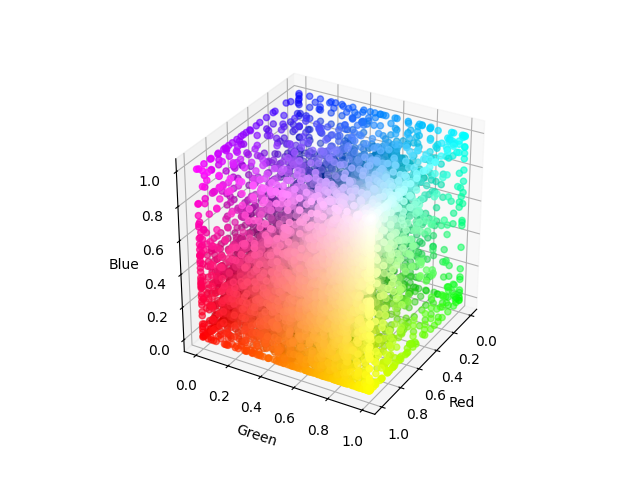

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import cast
from matplotlib.figure import Figure
import random


def plot_color_dots(
    ax: Axes3D,
    rate: float,
    labels: tuple[str, str, str],
    colors: Iterable[tuple[tuple[float, float, float], Color]],
):
    """Plot a scatter plot of colors in 3D."""
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])

    x: list[float] = []
    y: list[float] = []
    z: list[float] = []
    rgb: list[tuple[float, float, float]] = []
    for (r, g, b), color in colors:
        if random.random() > rate:
            continue
        x.append(r)
        y.append(g)
        z.append(b)
        rgb.append(color.channels)

    ax.scatter3D(x, y, z, c=rgb)  # type: ignore


def color_space_plot() -> tuple[Figure, Axes3D]:
    """Create a 3D scatter plot of the color space."""
    fig = plt.figure()
    axes = cast(Axes3D, fig.add_subplot(projection="3d"))
    axes.set_aspect("equal")
    axes.view_init(30, 30, 0)
    return (fig, axes)

fig, ax = color_space_plot()
plot_color_dots(ax, 1.0, ("Red", "Green", "Blue"), [(color.channels, color) for color in medoai_colors])
plt.show()

### Nearest-neighbor color matching

For each XTerm color, we want to find its nearest neighbors in the database.
This would mean checking each XTerm color's 3D distance against every color in
the database - in other words, the complexity is $O(N^2)$. With this database,
that would mean $30,000 \times 216 \approx 6,500,000$ distance checks. Not too
bad, on a modern computer, but not great if you want to reuse this database for
live lookups (and I do).

If we only had greyscale colors, then finding the nearest match would be easy:
just sort the array and do binary search. But we have three channels (R, G and
B), so we have to do something a little smarter.

In video games, collision detection and raytracing have to solve a similar
problem: checking ovelap between every pair of triangles in the scene would be
$O(N^2)$, but by dividing space into smaller volumes, it's possible to quickly
find things are that nearby, for some definition of *nearby.*

The most common data-structure for dividing space into such volumes is the
humble binary tree. Each node splits its bounding volume in two. The only trick
is that each level does the splitting along a different axis. This type of tree
has two names, depending on how we decide where to split the axis:

If the axis is always split down the middle, then we end up dividing the space
into smaller and smaller half-cubes, and this is called a *k-d tree.*

Alternatively, we can split the axis so that each side of the subtree contains
the same number of elements - the resulting volumes are smaller and uneven,
along with some empty spaces, but each volume is guaranteed to contain
*something.* Such a tree is called a *bounding volume hierarchy*, or BVH for
short.

As it turns out, RGB colors also exist in 3D space, with similar-looking colors
being near each other, so we can use this idea and build a BVH.

### Bounding Volumes

The *BV* in *BVH* stands for "Bounding Volume". This is basically just a simple
3D shape that's exactly large enough to completely contain some other, more
complicated 3D shape, like a point cloud. The simplest bounding volumes are
spheres and non-rotated boxes, called *Axis-Aligned Bounding Boxes,* or *AABB.* We
could actually split the color space into spheres, but an *AABB* is traditional,
so let's define one.

In [8]:
from typing import NamedTuple, Any, Iterable


class AABB(NamedTuple):
    """Axis-aligned bounding box."""

    lo: tuple[float, float, float]
    hi: tuple[float, float, float]

    @classmethod
    def from_point(cls, point: tuple[float, float, float]) -> "AABB":
        """A convenience constructor same as calling AABB(point, point)."""
        return cls(point, point)

    def overlaps(self, other: "AABB") -> bool:
        """Does this volume overlap with the other volume?"""
        return (
            self.hi[0] >= other.lo[0]
            and self.lo[0] <= other.hi[0]
            and self.hi[1] >= other.lo[1]
            and self.lo[1] <= other.hi[1]
            and self.hi[2] >= other.lo[2]
            and self.lo[2] <= other.hi[2]
        )

    def encapsulate(self, other: "AABB") -> "AABB":
        """Return a new AABB that bounds both self and the other."""
        return AABB(
            lo=(
                min(self.lo[0], other.lo[0]),
                min(self.lo[1], other.lo[1]),
                min(self.lo[2], other.lo[2]),
            ),
            hi=(
                max(self.hi[0], other.hi[0]),
                max(self.hi[1], other.hi[1]),
                max(self.hi[2], other.hi[2]),
            ),
        )

    def axis_center(self, axis: int) -> float:
        """The linear center of this box for the given axis."""
        return (self.lo[axis] + self.hi[axis]) / 2


def bounding_volume(volumes: Iterable[AABB]) -> AABB:
    """Bring all the volumes and in the darkness bound them."""
    volumes = iter(volumes)
    result = next(volumes)
    for volume in volumes:
        result = result.encapsulate(volume)
    return result



## BVH

OK, we have the volume defined, now what about the hierarchy? As discussed, a
BVH is a binary tree that divides a population of 3D volumes into half with each
step. The algorithm to query a BVH is a little different a regular BST, because
a volume might possibly overlap both left and right.

In [9]:
DIMENSIONS = 3


class BVH(NamedTuple):
    """Bounding volume hierarchy."""

    bounds: AABB
    value: Color|None
    left: "BVH|None"
    right: "BVH|None"
    depth: int

    def search(self, bounds: AABB) -> Iterable[tuple[AABB, Color]]:
        """Search for all values within the given bounds."""
        if self.bounds.overlaps(bounds):
            if self.value is not None:
                yield (self.bounds, self.value)
            if self.left is not None:
                yield from self.left.search(bounds)
            if self.right is not None:
                yield from self.right.search(bounds)

### Building a BVH

The algorithm to construct a BVH is almost identical to quicksort. Just like in
quicksort, each level of recursion picks a pivot element, and then swaps
elements until everything left of the pivot is smaller and everything right of
the pivot greater than the pivot.

Just like with quicksort, we need to pick a partition function - the code below
uses to often-taught Hoare Partition with a median-of-three algorithm for pivot
selection.

In [10]:

def make_bvh(data: list[tuple[AABB, Color]]) -> BVH:
    """Create a BVH from a list of AABBs and values."""
    if not data:
        raise ValueError("Must provide at least one volume")
    bounds = bounding_volume(aabb for aabb, _ in data)
    res = _make_bvh(data, 0, len(data) - 1, bounds, 0)
    assert res is not None
    return res


def _make_bvh(
    data: list[tuple[AABB, Any]], lo: int, hi: int, bounds: AABB, depth: int
) -> BVH | None:
    n = hi - lo + 1
    if n == 0:
        return None
    if n == 1:
        return BVH(bounds=data[lo][0], value=data[lo][1], left=None, right=None, depth=depth)
    if n == 2:
        return BVH(
            bounds=bounds,
            value=None,
            left=BVH(
                bounds=data[lo][0],
                value=data[lo][1],
                left=None,
                right=None,
                depth=depth + 1,
            ),
            right=BVH(
                bounds=data[hi][0],
                value=data[hi][1],
                left=None,
                right=None,
                depth=depth + 1,
            ),
            depth=depth,
        )

    # This part is basically quicksort, but with the partition using different
    # axes based on depth.
    axis = depth % DIMENSIONS
    mid = _hoare_partition(data, lo, hi, axis)
    left_bounds = bounding_volume(aabb for aabb, _ in data[lo:mid])
    right_bounds = bounding_volume(aabb for aabb, _ in data[mid : hi + 1])
    return BVH(
        bounds=bounds,
        value=None,
        left=_make_bvh(data, lo, mid - 1, left_bounds, depth + 1),
        right=_make_bvh(data, mid, hi, right_bounds, depth + 1),
        depth=depth,
    )


def _hoare_partition(a: list[tuple[AABB, BVH]], lo: int, hi: int, axis: int) -> int:
    pivot = a[_median_of_three(a, lo, hi, axis)][0].axis_center(axis)
    i = lo - 1
    j = hi + 1
    while True:
        i += 1
        while a[i][0].axis_center(axis) < pivot:
            i += 1
        j -= 1
        while a[j][0].axis_center(axis) > pivot:
            j -= 1
        if i >= j:
            return j
        a[i], a[j] = a[j], a[i]


def _median_of_three(a: list[tuple[AABB, BVH]], lo: int, hi: int, axis: int) -> int:
    """Median of three pivot selection adapted from quicksort."""
    mid = (lo + hi) // 2
    if a[mid][0].axis_center(axis) < a[lo][0].axis_center(axis):
        a[lo], a[mid] = a[mid], a[lo]
    if a[hi][0].axis_center(axis) < a[lo][0].axis_center(axis):
        a[lo], a[hi] = a[hi], a[lo]
    if a[mid][0].axis_center(axis) < a[hi][0].axis_center(axis):
        a[mid], a[hi] = a[hi], a[mid]
    return mid

We have a BVH - let's test it by looking for some colors similar to #FF8000, and see what we find.

In [11]:
color_db = make_bvh([(AABB.from_point(color.channels), color) for color in medoai_colors])
list(color_db.search(AABB((0.9, 0.5, 0.0), (1.0, 0.55, 0.0))))

[(AABB(lo=(0.9019607843137255, 0.5411764705882353, 0.0), hi=(0.9019607843137255, 0.5411764705882353, 0.0)),
  Color(names=['Hotter Butter'], channels=(0.9019607843137255, 0.5411764705882353, 0.0))),
 (AABB(lo=(0.9333333333333333, 0.5333333333333333, 0.0), hi=(0.9333333333333333, 0.5333333333333333, 0.0)),
  Color(names=['Clear Orange'], channels=(0.9333333333333333, 0.5333333333333333, 0.0))),
 (AABB(lo=(0.9411764705882353, 0.5137254901960784, 0.0), hi=(0.9411764705882353, 0.5137254901960784, 0.0)),
  Color(names=['Mikan Orange'], channels=(0.9411764705882353, 0.5137254901960784, 0.0))),
 (AABB(lo=(0.9490196078431372, 0.5215686274509804, 0.0), hi=(0.9490196078431372, 0.5215686274509804, 0.0)),
  Color(names=['Tangerine Skin'], channels=(0.9490196078431372, 0.5215686274509804, 0.0))),
 (AABB(lo=(1.0, 0.5450980392156862, 0.0), hi=(1.0, 0.5450980392156862, 0.0)),
  Color(names=['American Orange'], channels=(1.0, 0.5450980392156862, 0.0))),
 (AABB(lo=(1.0, 0.5490196078431373, 0.0), hi=(1.0

OK, that looks about right, we have a few shades of orange. To understand how
the BVH works, though, it'd be helpful to visualize the recursive search in 3D,
like we did with the colors themselves. First, let's slightly modify the search
function to generate a trace.

In [12]:
def trace_bvh_search(bvh, bounds: AABB) -> Iterable[BVH]:
    """Search for all values within the given bounds, yielding a full trace,
    including nodes without values."""
    if bvh.bounds.overlaps(bounds):
        yield bvh
        if bvh.left is not None:
            yield from trace_bvh_search(bvh.left, bounds)
        if bvh.right is not None:
            yield from trace_bvh_search(bvh.right, bounds)


Now we need a way to draw a 3D box. GPUs can only draw triangles, from what's
called a *mesh.* A mesh is commonly given as two arrays:

1. An array of *vertices* - points in 3D space
2. An array of *triangles* - triples of vertex numbers that form a triangle

Our 3D library does us a solid (that's a graphics pun) and lets us specify
arbitrary polygons, like rectangles, and it splits those into triangles for us.
So what we need to provide is a list of vertices, and their connections.

Any 3D "box" is always going to have the same connections between its vertices,
so that part is simple:

In [13]:
BOX_SIDES = [
    (0, 1, 2, 3),
    (0, 4, 5, 1),
    (1, 5, 6, 2),
    (2, 6, 7, 3),
    (3, 7, 4, 0),
    (4, 5, 6, 7),
]
"""The indices of the corners of each face of a box."""


'The indices of the corners of each face of a box.'

We can get vertices from the `AABB` volume we declared earlier, like so:

In [14]:
import numpy
from typing import Collection


def aabb_vertices(aabb: AABB) -> Collection[tuple[float, float, float]]:
    return numpy.array(
        [
            aabb.lo,
            (aabb.hi[0], aabb.lo[1], aabb.lo[2]),
            (aabb.hi[0], aabb.hi[1], aabb.lo[2]),
            (aabb.lo[0], aabb.hi[1], aabb.lo[2]),
            (aabb.lo[0], aabb.lo[1], aabb.hi[2]),
            (aabb.hi[0], aabb.lo[1], aabb.hi[2]),
            aabb.hi,
            (aabb.lo[0], aabb.hi[1], aabb.hi[2]),
        ]
    )


def aabb_mesh(vertices) -> Any:
    """Return the vertices of the box as a list of faces, in the format that
    pyplot expects."""
    return [[vertices[i] for i in side] for side in BOX_SIDES]

Now we just need some unremarkable drawing code, lifted straight from the
documentation.

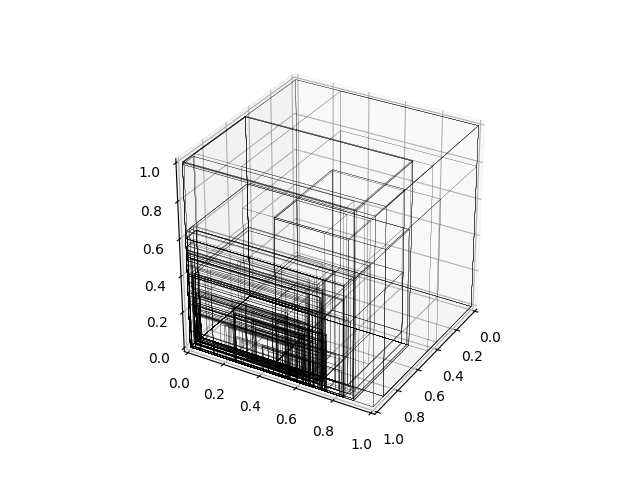

In [15]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_aabb(axes: Any, aabb: AABB, color: str = "#0000ff", alpha: float = 0.05):
    v = aabb_vertices(aabb)
    axes.add_collection3d(
        Poly3DCollection(
            aabb_mesh(v),
            facecolors=color,
            linewidths=0.1,
            edgecolors="k",
            alpha=alpha,
            zsort="max",
        )
    )


def plot_bvh_trace(axes: Any, bvh: BVH, bounds: AABB) -> None:
    for node in trace_bvh_search(bvh, bounds):
        if node.value is None:
            plot_aabb(axes, node.bounds, color="#0000ff", alpha=0.0001)
        else:
            plot_aabb(
                axes, node.bounds, color=f"#{rgb_to_hex(node.value.channels)}", alpha=0.0001
            )


fig, axes = color_space_plot()
plot_bvh_trace(axes, color_db, AABB((0.9, 0.5, 0.0), (1.0, 0.55, 0.0)))

plt.show()

And there you go - a BVH search for a few shades of orange. Each recursion level
is smaller, and most of the tree didn't need to be checked.

We can use this same approach to find colors similar to other colors.

### Finding Similar Shades

In [16]:
MAX_MATCHES = 5

for color in colors:
    r, g, b = color.channels
    max_dist = 0.15
    near_matches = list(
        color_db.search(
            AABB(
                lo=(r - max_dist, g - max_dist, b - max_dist),
                hi=(r + max_dist, g + max_dist, b + max_dist),
            )
        )
    )
    # Sort the matches by square distance
    dist = lambda x: sum((a - b) ** 2 for a, b in zip(x[0].lo, (r, g, b)))
    near_matches.sort(key=dist)
    for _, color2 in near_matches[:MAX_MATCHES]:
        color.names.extend(color2.names)

display.HTML("\n".join(colors_html(colors)))

## Making an rgb.txt

The `rgb.txt` file format, as used by X11, is just one color per line, lower
case name followed by `#hex` of the color. Optionally, lines starting with `#`
are comments. Let's make one for xterm. We'll use the best match to name each
color.

In [17]:
# This slide is skipped - it just defines a boring helper to display attachments
# as downloadable files.

import base64
import html


def display_attachment(
    data: bytes | str, filename: str, mime: str = "application/octet-stream"
) -> display.HTML:
    """Display a file attachment in the notebook."""
    if isinstance(data, str):
        data = data.encode("utf-8")

    data_b64 = base64.b64encode(data).decode("utf-8")
    href = f"data:{mime};base64,{data_b64}"
    filename = html.escape(filename)
    return display.HTML(
        f'<a class="download-link" data-mime-type="{html.escape(mime)}" download="{filename}" href="{href}">{filename}</a>'
    )

In [18]:
colors_by_name: dict[str, Color] = {
    name: color for color in colors for name in color.names[1:]
}

display_attachment(
    data="\n".join(
        f"{name.lower()}\t#{rgb_to_hex(color.channels)}"
        for name, color in colors_by_name.items()
    ),
    filename="rgb-xterm.txt",
)

Let's also make a second file that uses xterm indices instead of RGB colors -
this is easier to use with commands like `tput`.

In [19]:
display_attachment(
    data="\n".join(
        f"{name.lower()}\t{color.names[0]}"
        for name, color in colors_by_name.items()
    ),
    filename="xterm-256.txt",
)

## Some other uses for a color database

There are some other neat things we can do, now that we have a color database.
Interesting things become possible if we index by Hue-Luminance-Saturation (HLS)
instead of Red-Green-Blue. Here's what the color space looks like:

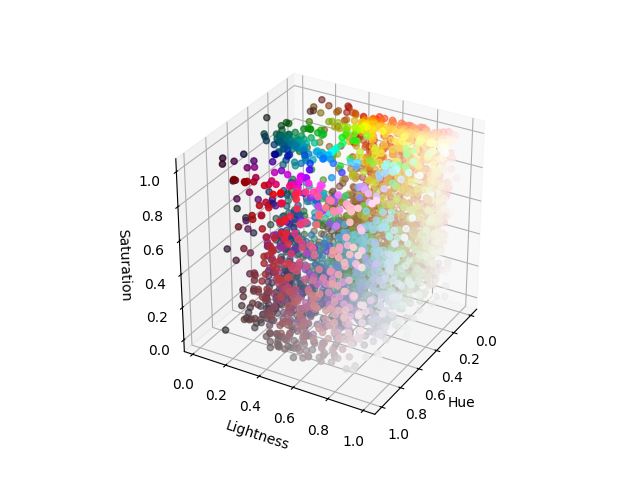

In [20]:
import colorsys

fig, axes = color_space_plot()
plot_color_dots(
    axes,
    0.1,
    ("Hue", "Lightness", "Saturation"),
    [(colorsys.rgb_to_hls(*color.channels), color) for color in medoai_colors],
)

And here's how easy it is to rebuild the BVH. HLS is still three dimensions, so
all we need to do is substitute a different 3-tuple instead of RGB.

Let's use this to find some highly saturated shades of blue.

In [21]:
colors_by_hls = make_bvh(
    [
        (AABB.from_point(colorsys.rgb_to_hls(*color.channels)), color)
        for color in medoai_colors
    ]
)

lo_hls = (0.55, 0.55, 0.95)
hi_hls = (0.6, 0.6, 1.0)
results = list(colors_by_hls.search(AABB(lo_hls, hi_hls)))
display.HTML("\n".join(colors_html([color for _, color in results])))

We can take a look at where these colors are located in the new BVH, as well:

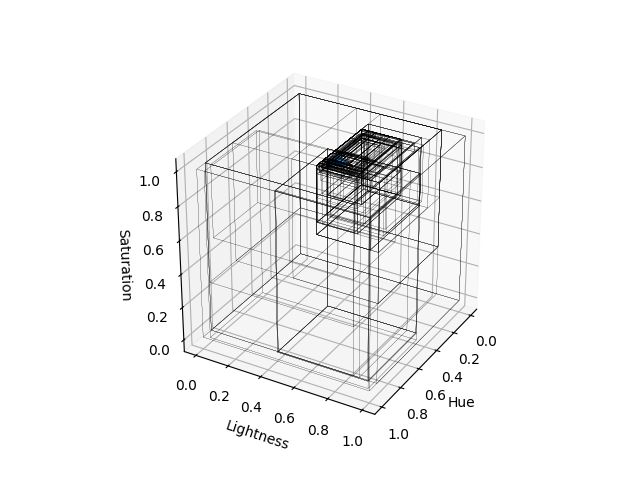

In [22]:
fig, axes = color_space_plot()
plot_bvh_trace(axes, colors_by_hls, AABB(lo_hls, hi_hls))
plot_color_dots(
    axes,
    1.0,
    ("Hue", "Lightness", "Saturation"),
    [(bounds.lo, color) for bounds, color in results],
)

### Useful Functions

All of this lets us define some neat utility functions for applications working with color.

In [23]:
class ColorDB:
    _by_hls: BVH
    _by_name: dict[str, Color]

    def __init__(self, colors: Iterable[Color]):
        self._by_name = {
            self._normalize_name(name): color
            for color in colors
            for name in color.names
        }
        self._by_hls = make_bvh(
            [
                (AABB.from_point(colorsys.rgb_to_hls(*color.channels)), color)
                for color in colors
            ]
        )

    def color_by_name(self, name: str) -> Color | None:
        return self._by_name.get(self._normalize_name(name))
    
    def similar_colors(self, color: Color, max_dist: float) -> Iterable[Color]:
        h, l, s = colorsys.rgb_to_hls(*color.channels)
        lo_hls = (h - max_dist, l - max_dist, s - max_dist)
        hi_hls = (h + max_dist, l + max_dist, s + max_dist)
        return (color for _, color in self._by_hls.search(AABB(lo_hls, hi_hls)))
    
    def shades_of(self, name: str, max_dist: float) -> Iterable[Color]:
        color = self.color_by_name(name)
        if color is None:
            return []
        # Find similar shades of grey by luminance, otherwise similar shades of
        # color by hue.
        h, l, s = colorsys.rgb_to_hls(*color.channels)
        if s < 0.1:
            lo_hls = (0, l - max_dist, 0)
            hi_hls = (1, l + max_dist, 1)
        else:
            lo_hls = (h - max_dist, 0.2, 0.1)
            hi_hls = (h + max_dist, 0.9, 1.0)

        return (color for _, color in self._by_hls.search(AABB(lo_hls, hi_hls)))

    @staticmethod
    def _normalize_name(name: str) -> str:
        return name.lower().strip()


For example, we can now query the XTerm color space for available shades of red:

In [24]:
db = ColorDB(colors)
results = db.shades_of("red", 0.05)
display.HTML("\n".join(colors_html(results)))

Now isn't that just neat?